In [1]:
# !uv pip install ipykernel
# !uv pip install boto3 pillow gradio

In [2]:
import gradio as gr
import boto3
import json
import base64
from PIL import Image
import io

from templates import templates

/Users/sangjae/Dev/sdxl_on_inf2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

def get_sagemaker_endpoints(region_name='us-west-2'):
    """SageMaker 엔드포인트 목록을 가져옵니다."""
    sagemaker_client = boto3.client('sagemaker', region_name=region_name)
    response = sagemaker_client.list_endpoints()
    endpoints = [endpoint['EndpointName'] for endpoint in response['Endpoints']]
    return endpoints

def generate_image(prompt,  prompt_neg, endpoint_name, sel_template, steps=20, guidance_scale=7.5, strength=0.1):
    """SageMaker 엔드포인트를 호출하여 이미지를 생성합니다."""
    try:
        # AWS 클라이언트 생성
        runtime = boto3.client("sagemaker-runtime")
        
        prompt_pos = templates[sel_template]['pos'].format(prompt=prompt)
        prompt_neg = templates[sel_template]['neg'] + prompt_neg

        print(sel_template)
        print("pos:", prompt_pos)
        print("neg:", prompt_neg)
        # 요청 데이터 생성
        payload = {
            "inputs": prompt_pos,
            "parameters": {
                "num_inference_steps" : steps,
                "negative_prompt" : prompt_neg
            }
        }

        # SageMaker 엔드포인트로 요청 전송
        response = runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="application/json",
            Body=json.dumps(payload)
        )

        # 응답 처리
        result = json.loads(response["Body"].read().decode())

        # print(result.keys())

        # 이미지 데이터 추출 및 변환
        generated_image_data = base64.b64decode(result["generated_images"][0])
        image = Image.open(io.BytesIO(generated_image_data))

        return image, "이미지 생성 성공!"

    except Exception as e:
        return None, f"오류 발생: {str(e)}"


In [9]:
# 엔드포인트 목록 가져오기
endpoints = get_sagemaker_endpoints()
default_endpoint = endpoints[0] if endpoints else ""
print(endpoints)

['huggingface-pytorch-inference-neuronx-2025-04-22-11-28-53-685', 'basic-jumpstart-deploy-llama3-2-1b-01']


In [10]:
profiles = list(templates.keys())
profiles

['anime',
 '3d_model',
 'concept_art',
 'breathtaking',
 'ethereal_fantasy',
 'isometric_style',
 'low_poly_style',
 'neonpunk_style',
 'cinematic_photo',
 'pixel_art',
 'food_photography',
 'luxury_product',
 'retail_packaging',
 'abstract_style',
 'art_deco_style',
 'art_nouveau_style',
 'cubist_artwork',
 'hyperrealistic_art',
 'impressionist_painting',
 'pointillism_style',
 'pop_art_style',
 'biomechanical_style',
 'biomechanical_cyberpunk',
 'cybernetic_style',
 'cybernetic_robot',
 'futuristic_style',
 'sci_fi_style',
 'bubble_bobble_style',
 'super_mario_style',
 'minecraft_style',
 'pokemon_style',
 'retro_game_art',
 'legend_of_zelda_style',
 'kawaii_style',
 'minimalist_style',
 'flat_papercut_style',
 'alien_themed']

In [20]:
# Gradio 인터페이스 생성
with gr.Blocks(title="SageMaker SDXL 이미지 생성기") as demo:
    gr.Markdown("# SageMaker SDXL 이미지 생성기")
    gr.Markdown("프롬프트를 입력하고 이미지를 생성해보세요.")

    with gr.Row():
        with gr.Column(scale=1):
            # 입력 컴포넌트
            endpoint_dropdown = gr.Dropdown(
                choices=endpoints,
                value=default_endpoint,
                label="SageMaker 엔드포인트 선택"
            )
            
            sel_template = gr.Dropdown(
                choices=profiles,
                value="anime",
                label="Prompt Template 선택"
            )

            prompt_input = gr.Textbox(
                label="프롬프트",
                placeholder="portrait of a beautiful person, smooth skin, photorealistic...",
                lines=3
            )

            prompt_input_neg = gr.Textbox(
                label="부정 프롬프트",
                placeholder="plastic skin, plasitic eyes ... ",
                lines=3
            )
            
            

            with gr.Accordion("고급 설정", open=False):
                # width_slider = gr.Slider(minimum=256, maximum=1024, value=512, step=64, label="너비")
                # height_slider = gr.Slider(minimum=256, maximum=1024, value=512, step=64, label="높이")
                steps_slider = gr.Slider(minimum=10, maximum=50, value=20, step=1, label="추론 단계")
                guidance_slider = gr.Slider(minimum=1.0, maximum=20.0, value=7.5, step=0.5, label="가이던스 스케일")
                strength_slider = gr.Slider(minimum=0.0, maximum=1.0, value=0.1, step=0.05, label="강도")

            generate_btn = gr.Button("이미지 생성", variant="primary")

        with gr.Column(scale=1):
            # 출력 컴포넌트
            output_image = gr.Image(label="생성된 이미지")
            output_message = gr.Textbox(label="상태 메시지")

    # 이벤트 핸들러 연결
    generate_btn.click(
        fn=generate_image,
        inputs=[
            prompt_input,
            prompt_input_neg,
            endpoint_dropdown,
            sel_template,
            # width_slider,
            # height_slider,
            steps_slider,
            guidance_slider,
            strength_slider
        ],
        outputs=[output_image, output_message]
    )

In [21]:
prompt_input = "a girl with a cat"
prompt_input_neg = "plastic eyes"
endpoint_dropdown = 'huggingface-pytorch-inference-neuronx-2025-04-22-11-28-53-685'
# width_slider = 512
# height_slider = 512
steps_slider = 20
guidance_slider = 1
strength_slider = 0.1

image, ret_text = generate_image(prompt_input, prompt_input_neg, endpoint_dropdown, "anime", steps_slider , guidance_slider , strength_slider  )


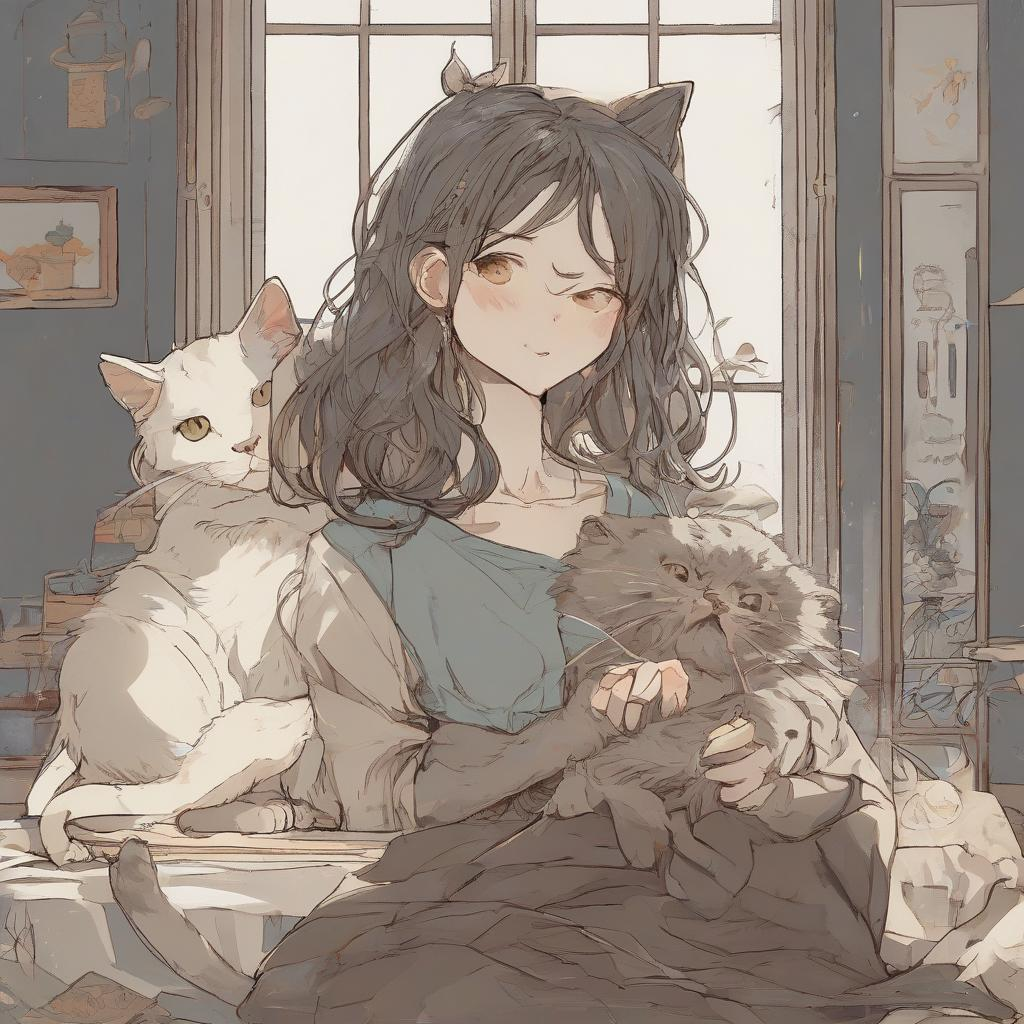

In [22]:
import IPython.display as ipd
ipd.display(image)

dict_keys(['anime', '3d_model', 'concept_art', 'breathtaking', 'ethereal_fantasy', 'isometric_style', 'low_poly_style', 'neonpunk_style', 'cinematic_photo', 'pixel_art', 'food_photography', 'luxury_product', 'retail_packaging', 'abstract_style', 'art_deco_style', 'art_nouveau_style', 'cubist_artwork', 'hyperrealistic_art', 'impressionist_painting', 'pointillism_style', 'pop_art_style', 'biomechanical_style', 'biomechanical_cyberpunk', 'cybernetic_style', 'cybernetic_robot', 'futuristic_style', 'sci_fi_style', 'bubble_bobble_style', 'super_mario_style', 'minecraft_style', 'pokemon_style', 'retro_game_art', 'legend_of_zelda_style', 'kawaii_style', 'minimalist_style', 'flat_papercut_style', 'alien_themed'])


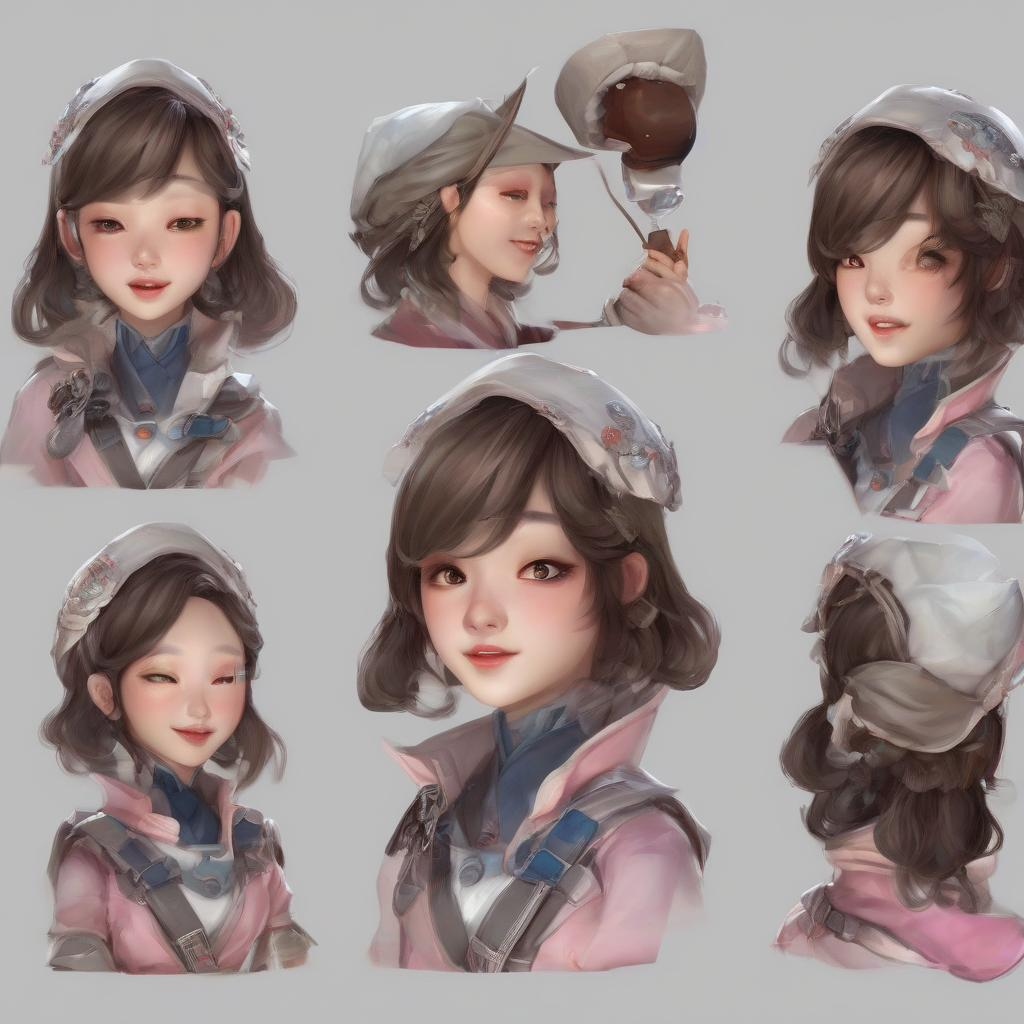

In [23]:
print(templates.keys())
profile = "low_poly_style"

prompt = "game character korean girl"
prompt_neg=""
# template = templates[profile]
# print(template, type(template))
# prompt = template['pos'].format(prompt="game character korean girl")
# prompt_neg = template['neg']

image, ret_text = generate_image(prompt, prompt_neg, endpoint_dropdown, profile)
ipd.display(image)

In [30]:
# demo.launch(share=True)
demo.launch(server_port=8889)
# demo.launch()

* Running on local URL:  http://127.0.0.1:8889

To create a public link, set `share=True` in `launch()`.


In [31]:
demo.close()

Closing server running on port: 8889
